# Wheel Test 2018-09-27
Testing new magic wheels on Jif.

In [1]:
%matplotlib inline
import pandas as pd

In [2]:
date = '2018-09-27'
activity_meta = pd.read_pickle("data/meta-%s.pkl.gz" % date)
activity_data = pd.read_pickle("data/data-%s.pkl.gz" % date)

## TPI Grouped by Direction
Select and pivot summary data for an activity.

In [3]:
pivot = activity_data.pivot(index='id', columns='measure', values='value')
activity = pd.merge(activity_meta, pivot, on='id')
activity['tpi'] = activity['actual_ticks'] / activity['actual_distance']
activity[['direction','actual_distance', 'tpi']].groupby('direction').describe().round(1)

actual_distance                                                 \
                    count   mean  std    min    25%    50%    75%    max   
direction                                                                  
-90.0                10.0  130.3  0.6  129.5  129.9  130.1  130.8  131.2   
0.0                  10.0  127.2  1.7  125.4  126.2  126.8  128.4  130.5   
180.0                10.0  131.4  0.5  130.6  131.1  131.4  131.8  132.1   
90.0                 10.0  129.0  0.5  128.2  128.7  129.2  129.4  129.8   

            tpi                                                        
          count    mean   std     min     25%     50%     75%     max  
direction                                                              
-90.0      10.0  1922.8   9.2  1908.2  1915.8  1925.2  1926.8  1937.9  
0.0        10.0  1977.4  19.6  1940.7  1966.5  1986.2  1989.2  1998.1  
180.0      10.0  1907.1   6.8  1900.6  1901.7  1905.0  1913.1  1918.7  
90.0       10.0  1947.2   4.6  1937.5  1944.6  1947.6  1950.8  1952.7

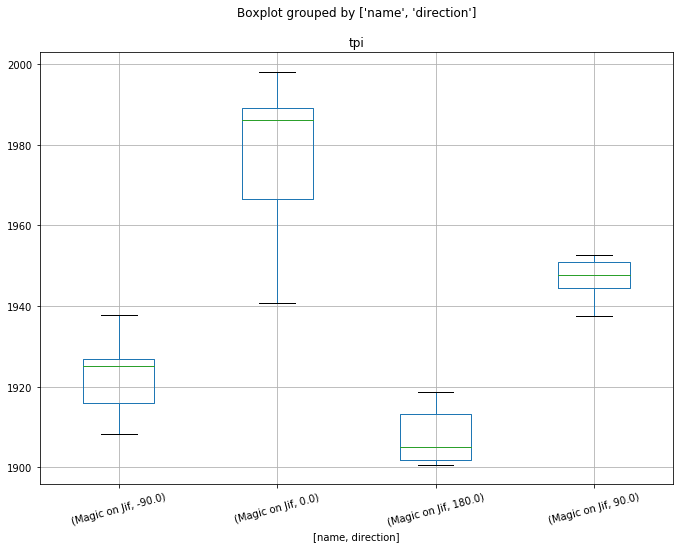

In [4]:
activity.boxplot(column='tpi', by=['name', 'direction'], rot=15, figsize=(11, 8))

## TPI Estimated Error by Direction
A resonable choice for nominal TPI is either *forward* TPI or TPI *grand mean*. We'll assume the TPI nominal value is the grand mean of all TPI measurements.

\begin{equation*}
error_{TPI} =  \frac{TPI_{experimental} - TPI_{nominal}}{TPI_{nominal}} \times 100\%
\end{equation*}

A positive error is more ticks per inch (conversely fewer inches per tick), therefore the robot travels less distance with postive error. The `100 in.` column below is how far we'd expect the robot to travel if we converted 100 in to ticks using the forward (0.0) TPI as our benchmark.

In [5]:
tpi_grand_mean = activity['tpi'].mean()
tpi_error = activity[['direction', 'tpi']].groupby('direction').mean()
tpi_error['error'] = (tpi_error['tpi'] - tpi_grand_mean) / tpi_grand_mean
tpi_error['error (%)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in tpi_error['error']], index = tpi_error.index)

ticks_100_in = tpi_error.loc['0.0','tpi'] * 100 # ticks to travel 100in using 0.0 TPI
tpi_error['100 in.'] = ticks_100_in / tpi_error['tpi']
tpi_error = tpi_error.round({'tpi':1, 'error': 3, '100 in.': 2})
tpi_error

,tpi,error,error (%),100 in.
direction,,,,
-90.0,1922.8,-0.008,-0.82%,102.84
0.0,1977.4,0.020,2.00%,100.00
180.0,1907.1,-0.016,-1.63%,103.69
90.0,1947.2,0.004,0.44%,101.55


## Notes

The data for `activity_meta` can be reconstructed from the datebase with this query:
    
```sql
SELECT id, name, timestamp, meta->'direction' AS direction
FROM tc_activity
WHERE timestamp::date = date '2018-09-27' AND data[3] <> 0
```

The data for `activity_data` can be reconstructed from the datebase with this query:

```sql
SELECT id, name, timestamp, measure, value
FROM tc_activity, unnest(activity_measures, data) AS u(measure, value)
WHERE timestamp::date = date '2018-09-27' AND data[3] <> 0
```